In [12]:
# import modules
from keras.layers import Input, Dense

# Create input layer here with shape 1. NOTE: the shape argument of the Input() functionr requires a tuple
input_tensor = Input(shape=(1,))

# Define output (Dense) layer of shape 1
output_layer = Dense(1, name='Predicted-Score')

# Connecting the two layers
output_tensor = output_layer(input_tensor)

# OR create output_layer and connect it to input layer in one step:
output_tensor = Dense(1)(input_tensor)

In [13]:
# Define model
from keras.models import Model
model = Model(input_tensor, output_tensor)

In [14]:
# Compile model (define loss, optimizer, hyperparameters)
model.compile(optimizer='adam', loss='mean_absolute_error')

# show summary of model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


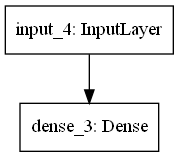

In [15]:
# Plotting a model
from keras.utils import plot_model
import pydotplus
from keras.utils import vis_utils
from keras.utils.vis_utils import model_to_dot
vis_utils.pydot = pydotplus

# plot + save the model graph plot
plot_model(model, to_file ='model.png')

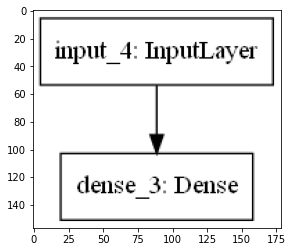

In [16]:
# visualise the saved plot
from matplotlib import pyplot as plt
img = plt.imread('model.png')
plt.imshow(img)
plt.show()

In [20]:
# Fit model
import pandas as pd
##  read data basketball game sexample
games = pd.read_csv('..\data\\test_data\\games_tourney.csv')
games.head()

## fit the model to input data
model.fit(games['seed_diff'],   # the predictor
          games['score_diff'],  # the target variable
          epochs=1,             # number of epochs
          batch_size=128,        # batch size
          validation_split=.20, # define cross-validation (holdout set) split
          verbose=True)         # show progress



27/27 [==============================] - 0s 2ms/step - loss: 16.5288 - val_loss: 15.48


In [21]:
# Evaluating the model
# Load the X variable from the test data
X_test = games['seed_diff']

# Load the y variable from the test data
y_test = games['score_diff']

# Evaluate the model on the test data
print(model.evaluate(X_test, y_test, verbose=False))

16.261810302734375


In [25]:
# Embeddings and Flattening
# embeddings can learn number representations from input data --> with colleague basketbatll, they can learn a strength rating for each class (creating a lookup table)
from keras.layers import Embedding
from numpy import unique

# get number of unique teams ( input dimension for embedding)
n_teams = unique(games['team_1']).shape[0]
n_teams

# create embedding
team_lookup = Embedding(input_dim = n_teams,        # as the input is a list of length n_teams
                        output_dim = 1,             # as we want to predict a single scalar per team
                        input_length = 1,           # as we input a single scalar (the team ID)
                        name = 'Team-Strength')

In [26]:
# adding a flatten layer to reduce the 3D output of embedding layer to 2D and create model
from keras.layers import Flatten
# create input layer
teamid_in = Input(shape=(1,))

# lookup the input in the strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine operations into model
team_strength_model = Model(teamid_in, strength_lookup_flat, name = 'Team-Strength-Model')
team_strength_model.summary()


Model: "Team-Strength-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
Team-Strength (Embedding)    (None, 1, 1)              2150      
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
Total params: 2,150
Trainable params: 2,150
Non-trainable params: 0
_________________________________________________________________


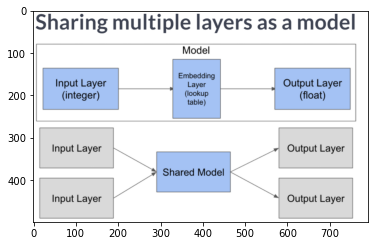

In [29]:
# Shared Layers --> e.g. input layer per team (Team 1 and Team 2) but we want to use the same embedding layer --> 'shared layer'
img = plt.imread('Shared-Layers-Schema.PNG')
plt.imshow(img)
plt.show()

# Sharing a layer/model

# input layer for team 1
team_in_1 = Input(shape=(1,), name = 'Team-1-In')

# input layer for team 2
team_in_2 = Input(shape=(1,), name = 'Team-2-In')

"""
Now that you have a team strength model and an input layer for each team, you can lookup the team inputs in the shared team strength model.
The two inputs will share the same weights.

In this dataset, you have 10,888 unique teams.
You want to learn a strength rating for each team, such that if any pair of teams plays each other,
you can predict the score, even if those two teams have never played before.
Furthermore, you want the strength rating to be the same, regardless of whether the team is the home team or
the away team.
"""

# implement shared layer (here a model built previously team_strength_model()
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

In [38]:
"""
now that we have multiple inputs, we also get multiple outputs. Therefore, we need a layer to merge these into 1 predictor --> Merge layers
there are several types of merge layers:

- Add
- Subtract
- Multiply
- Concatenate (can work on layers with different shapes)

"""

# here we use the Subtract() layer to calculate the difference in team strength (as learned via the team_strength_model()
from keras.layers import Subtract

score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile model
model.compile(optimizer='adam', loss='mean_absolute_error')

# train the model
input_1 = games['team_1']
input_2 = games['team_2']

model.fit([input_1, input_2],
          games['score_diff'],
          epochs = 1,
          batch_size = 2048,
          validation_split = .10,
          verbose = True)


InvalidArgumentError:  indices[0,0] = 8420 is not in [0, 2150)
	 [[node model_10/Team-Strength-Model_1/Team-Strength/embedding_lookup (defined at <ipython-input-38-38547acbc178>:27) ]] [Op:__inference_train_function_3041]

Errors may have originated from an input operation.
Input Source operations connected to node model_10/Team-Strength-Model_1/Team-Strength/embedding_lookup:
 model_10/Team-Strength-Model/Team-Strength/embedding_lookup/2845 (defined at c:\users\getecer\appdata\local\programs\python\python38\lib\contextlib.py:113)

Function call stack:
train_function


In [ ]:
# 3 Input models
# here with a concatenate layer (other merge layers could be used)
# essentially works the same but we give a list of 3 inputs into the model training and evaluation


# Stacking Models

it's important to use DIFFERENT DATASETs for each model being stacked!!
e.g.:

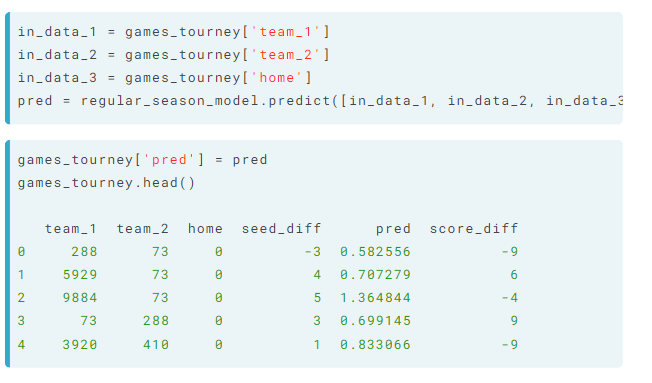


Stacking two Models:

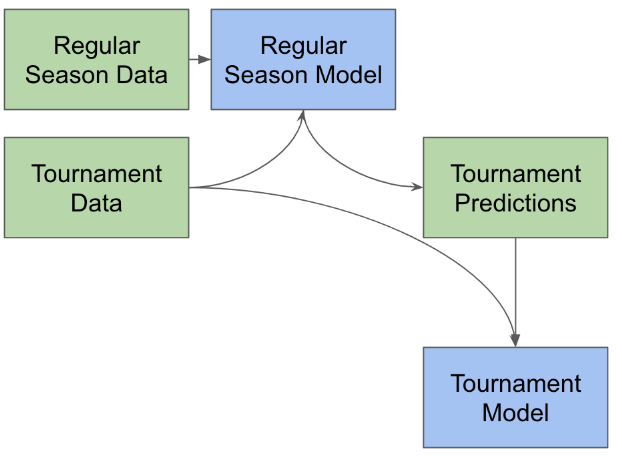

'Stacking' by having a multidimensional Input Layer

*This requires all input columns to have a numerical data type*

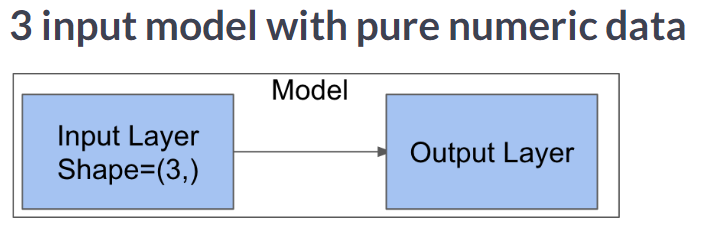

Implementation:

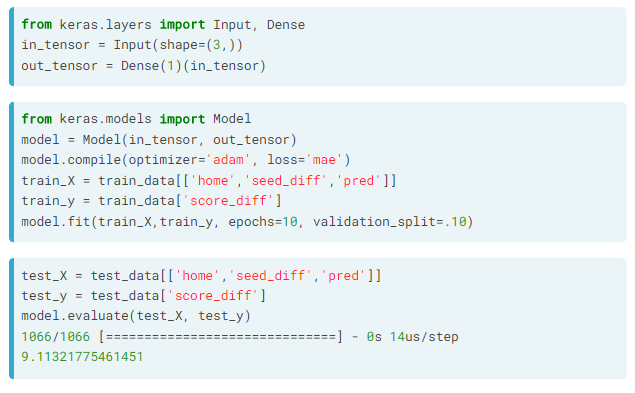
